# Algeria Dataset Group Project

**Introduction**

Understanding how forest fires start is essential to preventing loss to the economy, the environment, and people. Researchers have been examining the causes of fire breakouts in the Algerian region in an effort to prevent them in the future (Abid & Izeboudhen, 2020). Several experts agree that a number of variables, including temperature, topography, vegetation, precipitation, and many others, may serve as fire start-amplifying factors (Belgherbi et al., 2018; Fekir et al., 2022). Our team has therefore chosen to look into the question of "Can humidity, temperature, windspeed, and rain accurately predict forest fires in Algeria using KNN classification?" These predictors were chosen with consideration for prior work that had highlighted their importance in predicting forest fires. For instance, it is well known that rain, wind, humidity, and temperature are important climatic variables that might affect the start and spread of forest fires (Belgherbi et al., 2018; Fekir et al., 2022). High temperatures and low humidity can make it easier for fires to start and spread, while rain and wind speed can have an impact on how quickly fires spread or are put out. The goal of our question is to hopefully enable our team to better understand the reasons behind forest fires in Algeria and create a predictive model to identify vulnerable areas. The dataset used in this project was obtained from the UCI Machine Learning Repository titled "Algerian Forest Fires Dataset"; we have linked the dataset below. The dataset contains information on various climatic variables, including humidity, temperature, wind speed, rain, and the occurrence of forest fires in Algeria. It provides a comprehensive record of climatic conditions and forest fire events, making it suitable for analyzing the relationship between these variables and predicting forest fires

https://archive.ics.uci.edu/ml/datasets/Algerian+Forest+Fires+Dataset++

**Methods & Results** 

To better understand the data set we are working with, the first step is to load, wrangle, and explore the data set we are working with. We first load the tidyverse package needed for our analysis, and tidymodels collection needed for making and using models (classifiers) in later steps.

In [1]:
# Importing libraries 
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In this case, the file containing the dataset is a .csv file with headers. We use the read_csv() to read the data directly from the website. Before making further analysis, we wrangle our data to make it into a tidy form. We use slice() and select() to keep only the wanted rows and columns. Since we will be working with Classes as a categorical statistical variable, we convert it to factor using the function as_factor(). And columns from Temperature to Ws are converted to the proper types.

In [2]:
# reading data
dataset_raw <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv", skip = 1)
# wrangling data
regional_dataset <- dataset_raw |>
                    slice(1:122) |>  
                    mutate(across(Temperature:Ws, as.integer),
                           Rain = as.numeric(Rain),
                           Classes = as.factor(Classes))|> 
                           select(Temperature:Rain, Classes)
regional_dataset <- regional_dataset |>
  na.omit(subset = c("Temperature", "Rain", "RH", "Ws"))

regional_dataset

Warning message:
“One or more parsing issues, see `problems()` for details”
Rows: 246 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (14): day, month, year, Temperature, RH, Ws, Rain, FFMC, DMC, DC, ISI, B...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Temperature,RH,Ws,Rain,Classes
<int>,<int>,<int>,<dbl>,<fct>
29,57,18,0.0,not fire
29,61,13,1.3,not fire
26,82,22,13.1,not fire
⋮,⋮,⋮,⋮,⋮
32,47,14,0.7,not fire
26,80,16,1.8,not fire
25,78,14,1.4,not fire


Table 1: Algerian forest fire dataset

The column names each stand for: 

    1. Temperature: temperature (max) noon in Celsius degrees
    2. RH: Relative Humidity in %
    3. Ws: Wind speed in km/h 
    4. Rain: total day rainfall in mm
    

In order to actually make predictions for new observations in practice, we will need a classification algorithm, specifically K-nearest neighbors (KNN). We begin the analysis by using the set.seed() to make our result reproducible. Then, we use the initial_split() to split the data into the training (75%) and test sets (25%).

In [3]:
set.seed(1234)

# splitting data into training and testing set
fire_split <- initial_split(regional_dataset, prop = 0.75, strata = Classes)
fire_training <- training(fire_split)
fire_testing <- testing(fire_split)

fire_training

Temperature,RH,Ws,Rain,Classes
<int>,<int>,<int>,<dbl>,<fct>
33,54,13,0,fire
30,73,15,0,fire
31,65,14,0,fire
⋮,⋮,⋮,⋮,⋮
31,54,11,0.0,not fire
32,47,14,0.7,not fire
25,78,14,1.4,not fire


Table 2: Algerian forest fire training set 

We use the group_by(), summarize(), and n() functions to find the number and percentage of fire and not fire observations in the training set. We have 44 (48.4%) fire and 47 (51.6%) not fire observations; two categories are balanced. We then draw several box plots to visualize the relationship between the variables.

In [4]:
# finding the number and percentage of fire and not fire observations in training set
num_obs <- nrow(fire_training)
fire_training |> group_by(Classes) |> 
                 summarize(count = n(), 
                           percentage = n()/num_obs * 100)

Classes,count,percentage
<fct>,<int>,<dbl>
fire,44,48.35165
not fire,47,51.64835


Table 3: Number and percentage of fire and not fire observations in training set

Warning message:
“`fun.y` is deprecated. Use `fun` instead.”


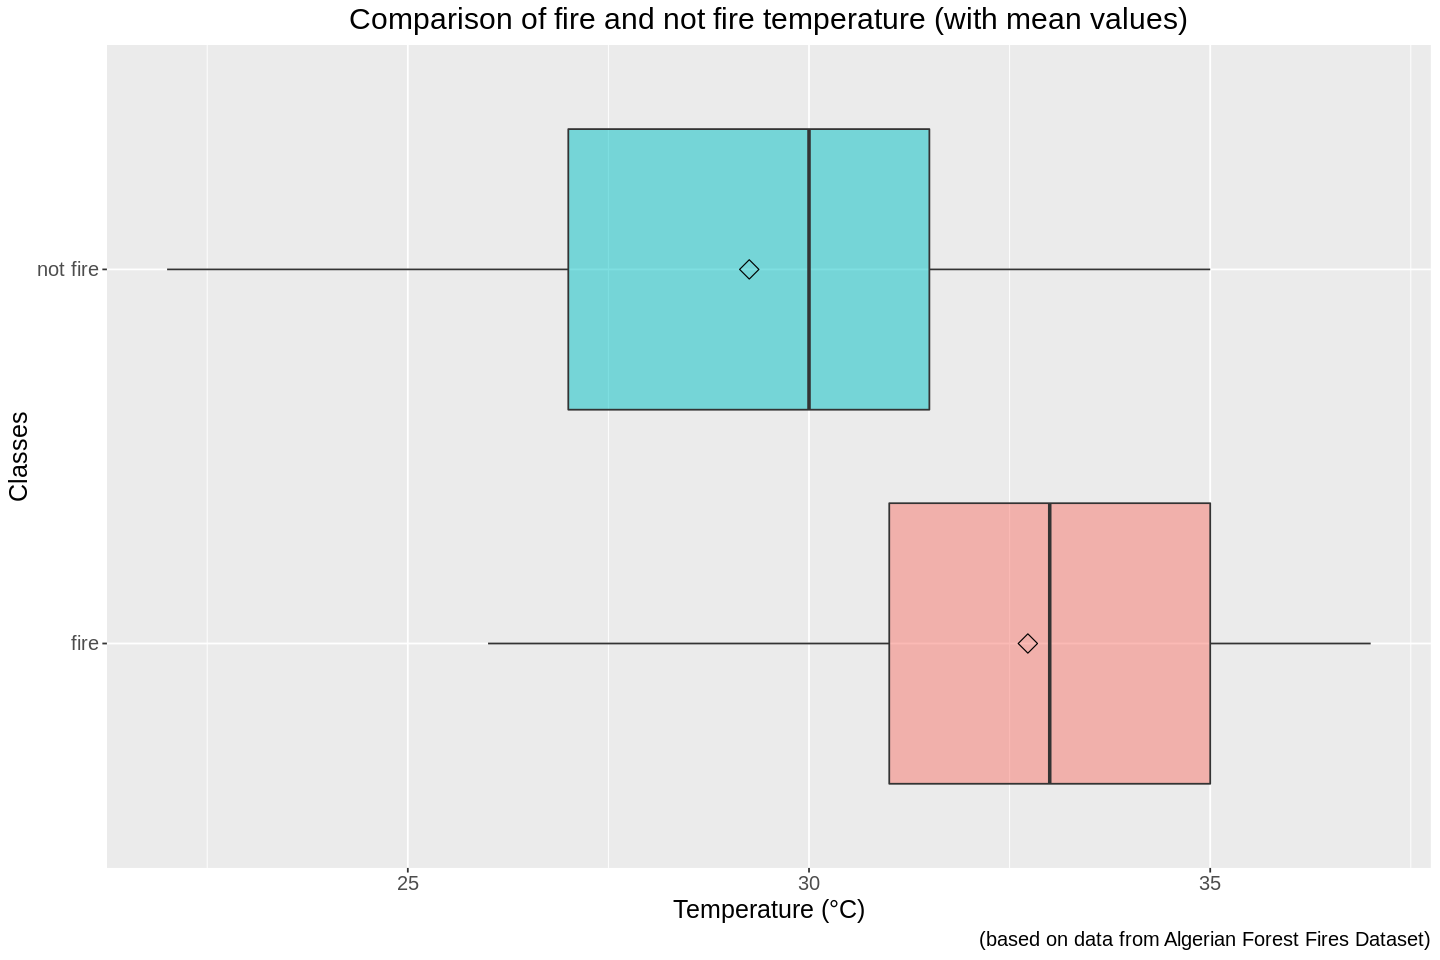

In [5]:
options(repr.plot.width = 12, repr.plot.height = 8)

# Visualizing the data by comparing the distributions of predictors 
# Boxplot for temperature (°C)
ggplot(fire_training, aes(x=Temperature, y=Classes)) + 
  geom_boxplot(alpha = 0.5, outlier.colour="black", outlier.shape=8,
                outlier.size=4, aes(fill = Classes), show.legend = FALSE) + 
  labs(x = "Temperature (°C)", y = "Classes", caption = "(based on data from Algerian Forest Fires Dataset)")+
  ggtitle("Comparison of fire and not fire temperature (with mean values)")+
  stat_summary(fun.y=mean, geom="point", shape=23, size=4) + 
  theme(text = element_text(size = 15), plot.title = element_text(hjust = 0.5)) 

Figure 1: Boxplot of comparison of fire and not fire temperature.

Warning message:
“`fun.y` is deprecated. Use `fun` instead.”


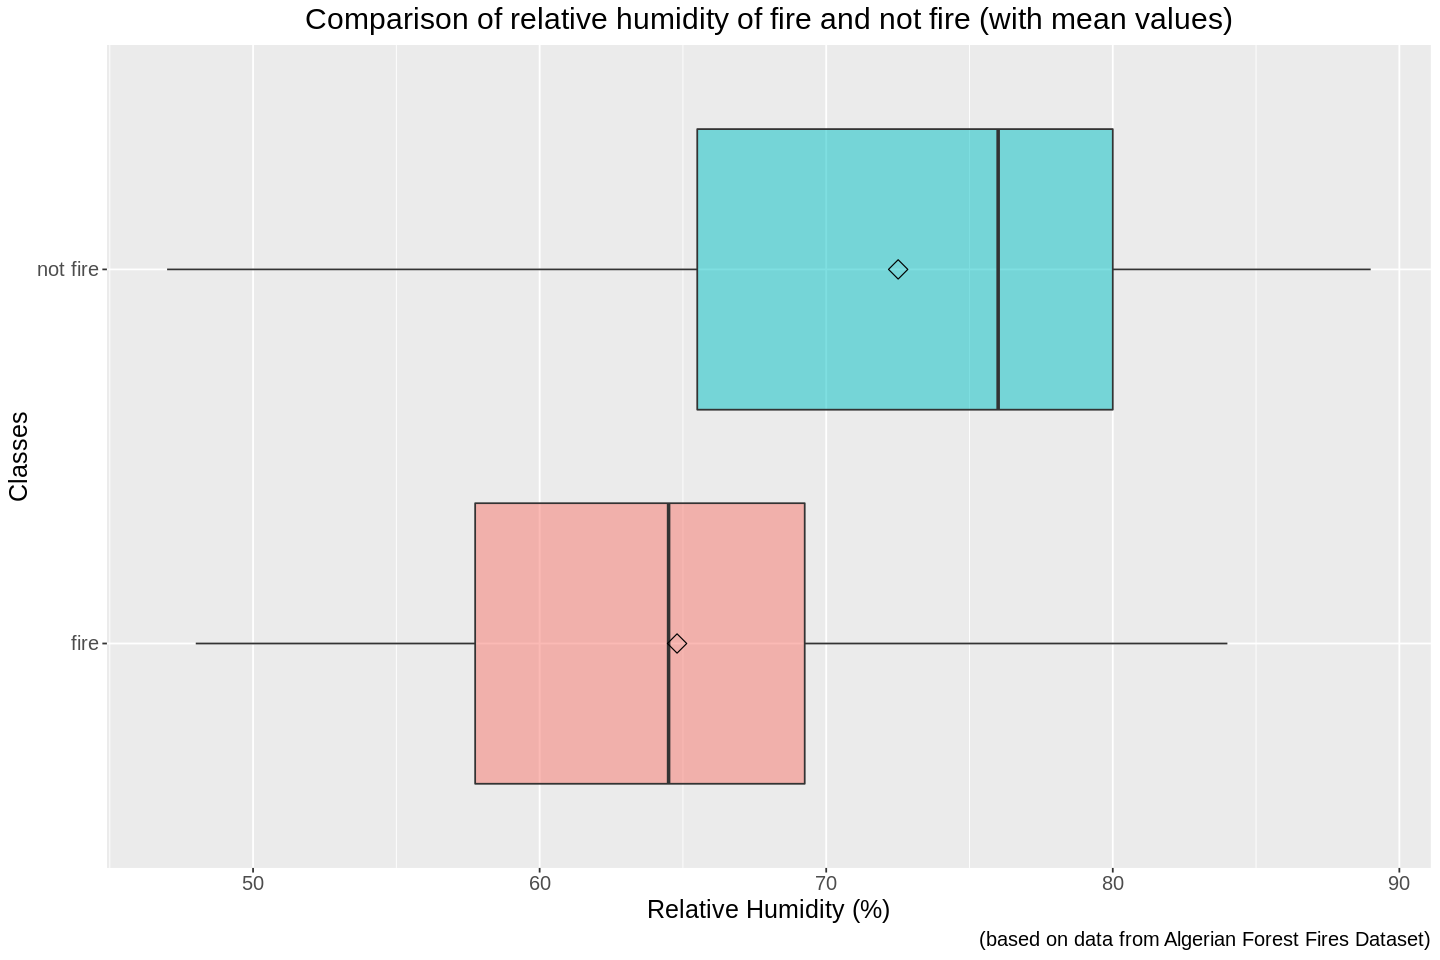

In [6]:
options(repr.plot.width = 12, repr.plot.height = 8)

# Boxplot for relative humidity (%)
ggplot(fire_training, aes(x=RH, y=Classes)) + 
  geom_boxplot(alpha = 0.5, outlier.colour="black", outlier.shape=8,
                outlier.size=4, aes(fill = Classes), show.legend = FALSE) + 
  labs(x = "Relative Humidity (%)", y = "Classes", fill = "Whether fire or not", caption = "(based on data from Algerian Forest Fires Dataset)")+
  ggtitle("Comparison of relative humidity of fire and not fire (with mean values)")+
  stat_summary(fun.y=mean, geom="point", shape=23, size=4) + 
  theme(text = element_text(size = 15), plot.title = element_text(hjust = 0.5))

Figure 2: Boxplot of comparison of relative humidity of fire and not fire.

Warning message:
“`fun.y` is deprecated. Use `fun` instead.”


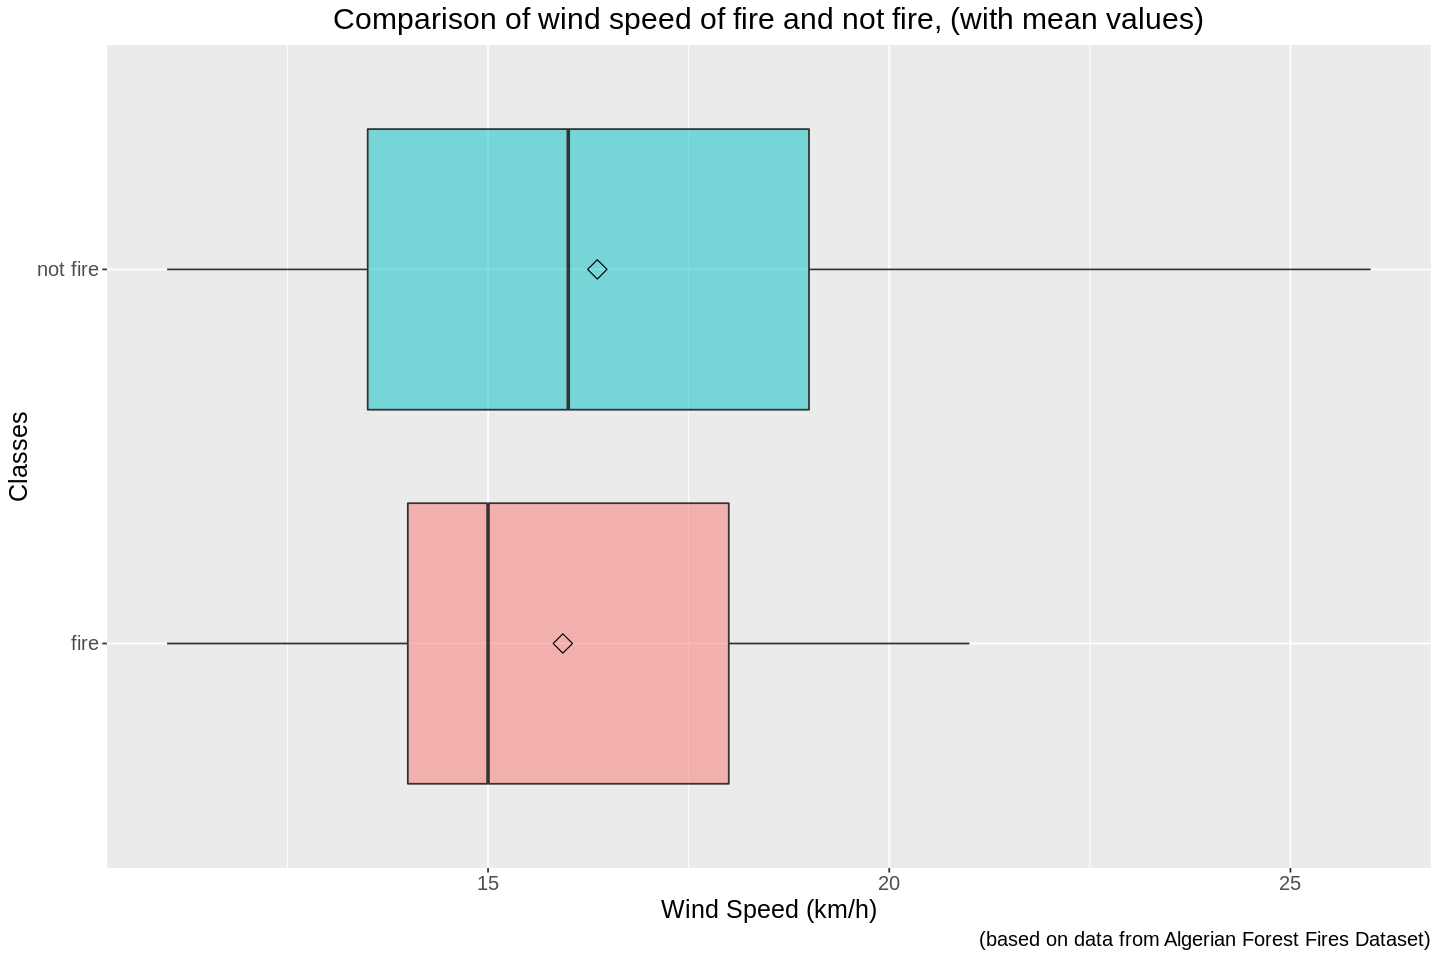

In [7]:
options(repr.plot.width = 12, repr.plot.height = 8)

# Boxplot for wind speed (km/h)
ggplot(fire_training, aes(x=Ws, y=Classes)) + 
  geom_boxplot(alpha = 0.5, outlier.colour="black", outlier.shape=8,
                outlier.size=4, aes(fill = Classes), show.legend = FALSE) + 
  labs(x = "Wind Speed (km/h)", y = "Classes", caption = "(based on data from Algerian Forest Fires Dataset)")+
  ggtitle("Comparison of wind speed of fire and not fire, (with mean values)")+
  stat_summary(fun.y=mean, geom="point", shape=23, size=4) + 
  theme(text = element_text(size = 15), plot.title = element_text(hjust = 0.5))

Figure 3: Boxplot of comparison of wind speed of fire and not fire.

Warning message:
“`fun.y` is deprecated. Use `fun` instead.”
Warning message:
“Removed 13 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 13 rows containing non-finite values (stat_summary).”


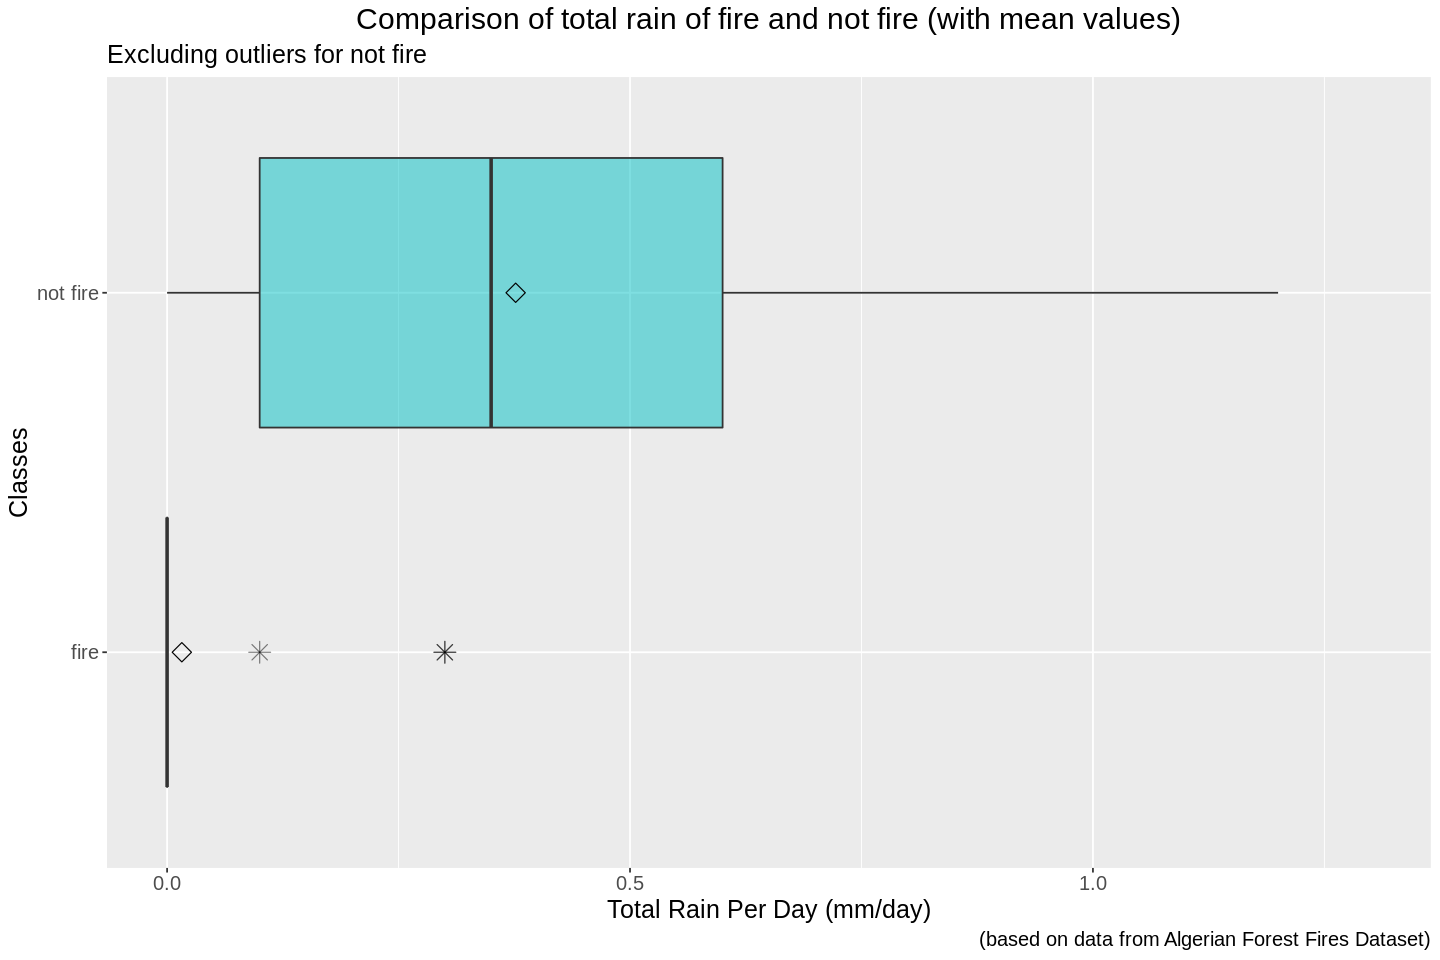

In [8]:
options(repr.plot.width = 12, repr.plot.height = 8)

# Boxplot for total rain (mm)
# Manully excluding outliers for not fire for better visualization 
ggplot(fire_training, aes(x=Rain, y=Classes)) + 
  geom_boxplot(alpha = 0.5, outlier.colour="black", outlier.shape=8,
                outlier.size=4, aes(fill = Classes), show.legend = FALSE) +
  xlim(0,1.3) +
  labs(x = "Total Rain Per Day (mm/day)", y = "Classes", fill = "Whether fire or not", caption = "(based on data from Algerian Forest Fires Dataset)")+
  ggtitle("Comparison of total rain of fire and not fire (with mean values)", subtitle = "Excluding outliers for not fire")+
  stat_summary(fun.y=mean, geom="point", shape=23, size=4) + 
  theme(text = element_text(size = 15), plot.title = element_text(hjust = 0.5))

Figure 4: Boxplot of comparison of daily rain fall of fire and not fire.

From the boxplots, we can see that mean higher temperatures, lower humidity, lower wind speeds, and no rain are correlated incidences of forest fires in Bejaia. The higher variation between incidences of fires and lack thereof when plotted against temperature, relative humidity, and rain may suggest them as stronger predictors, compared to wind speed.

We utilize cross-validation to assess and identify the accuracy for each K in the class vote in order to select the number of neighbors (parameter K value) that offers us the highest accuracy. Utilizing stratification and the vfold_cv() method to divide up the training data, we carry out 5-fold cross-validation.

In [9]:
#tune + vfold, how many vfolds do we want im going with 5 because we have like 200-something rows
#and we don't want too little data going on
set.seed(1234)

fire_vfold1 <- vfold_cv(fire_training, v = 5, strata = Classes)

Since KNN is sensitive to the scale of the predictors, we create the standardization preprocessor using only the training data before training the classifier. We standardize (centering/shifting/scaling) all predictors in the training data under the recipe framework.

In [10]:
fire_recipe_presumably <- recipe(Classes ~ Temperature + RH + Ws + Rain, data = fire_training) |>
                            step_scale(all_predictors()) |>
                            step_center(all_predictors())

To tune our model. we create a nearest_neighbors model specification, with neighbors = tune(). Then, we add the recipe and model specification to a workflow(), putting multiple data analysis steps together. Then, we fit the model for each value in a range of parameter values and calculate the classifier accuracy for them using the tune_grid() function on the train/validation splits. In this instance, the neighbours variable is created with values ranging from 1 to 50 (stepping by 1). We can then decide which K to choose by plotting K values against their respective accuracies.

In [11]:
fire_tune_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

fire_tune_fit <- workflow() |>
                    add_recipe(fire_recipe_presumably) |>
                    add_model(fire_tune_spec) |>
                    tune_grid(resamples = fire_vfold1, grid = k_vals) |>
                    collect_metrics() |> 
                    filter(.metric == "accuracy")

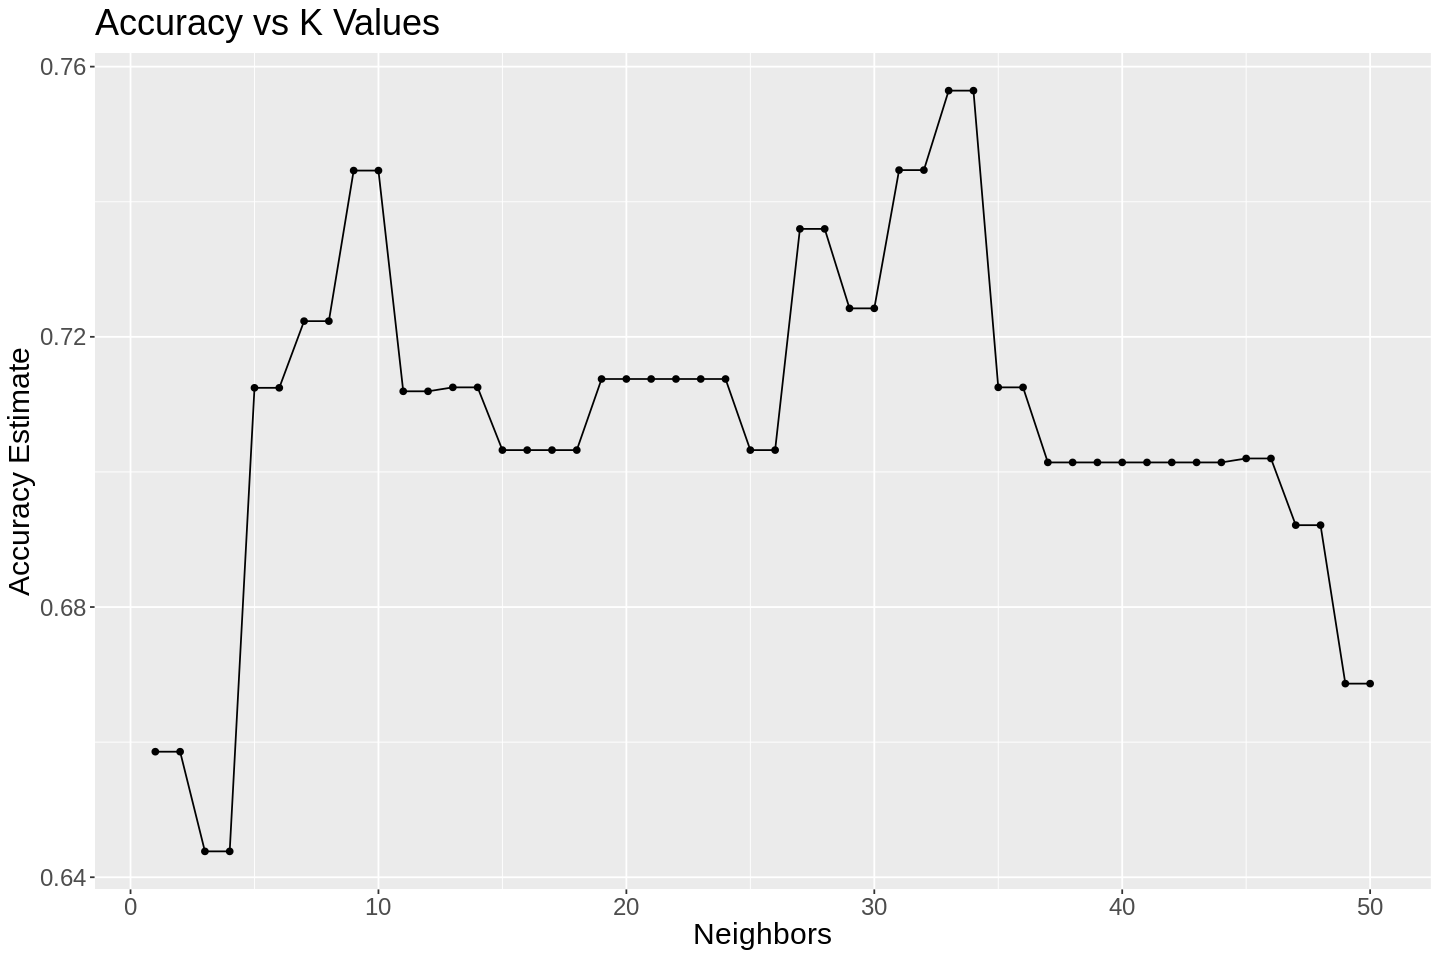

In [12]:
cross_val_plot <- fire_tune_fit |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    ggtitle("Accuracy vs K Values") + 
    theme(text = element_text(size = 18))

cross_val_plot

Figure 5: Plot of estimate accuracy versus the number of neighbors. 

Based on Figure 5, we can see that K = 33 or 34 provides the highest accuracy; however, we also need to consider whether it plateaus or not. We would choose K = 22. Now, we can make a new specification and retrain the classifier using the fit(). 

In [13]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 22) |> 
            set_engine("kknn") |> 
            set_mode("classification")
#knn_spec

fire_fit <- workflow() |>
                    add_recipe(fire_recipe_presumably) |>
                    add_model(knn_spec) |>
                    fit(data = fire_training)

The test data set's class labels may then be predicted using our final model, and the metrics() function can be used to assess the classifier's estimated accuracy.

In [14]:
# get the prediction column
fire_predictions <- predict(fire_fit, fire_testing) |>
                    #add the column of predictions to the original test data
                    bind_cols(fire_testing)
fire_predictions

.pred_class,Temperature,RH,Ws,Rain,Classes
<fct>,<int>,<int>,<int>,<dbl>,<fct>
fire,29,61,13,1.3,not fire
fire,31,67,14,0.0,fire
not fire,29,89,13,0.7,not fire
⋮,⋮,⋮,⋮,⋮,⋮
not fire,26,81,21,5.8,not fire
fire,31,66,11,0.0,fire
not fire,26,80,16,1.8,not fire


Table 4: Predicted class with original Algerian forest testing set

In [15]:
fire_accuracy <- fire_predictions |>
                    metrics(truth = Classes, estimate = .pred_class) |> 
                    filter(.metric == "accuracy")

fire_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7419355


Table 5: Accuracy of classifier

Looking at the value of the .estimate variable in the metrics data frame, the estimated accuracy of the classifier on the test data is 74.2%. We also include a confusion matrix for the classifier to see how predicted and correct labels distribute.

In [16]:
fire_confmat <- fire_predictions |>
                conf_mat(truth = Classes, estimate = .pred_class)

fire_confmat

          Truth
Prediction fire not fire
  fire       15        8
  not fire    0        8

Table 6: Confusion matrix from predicted results

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



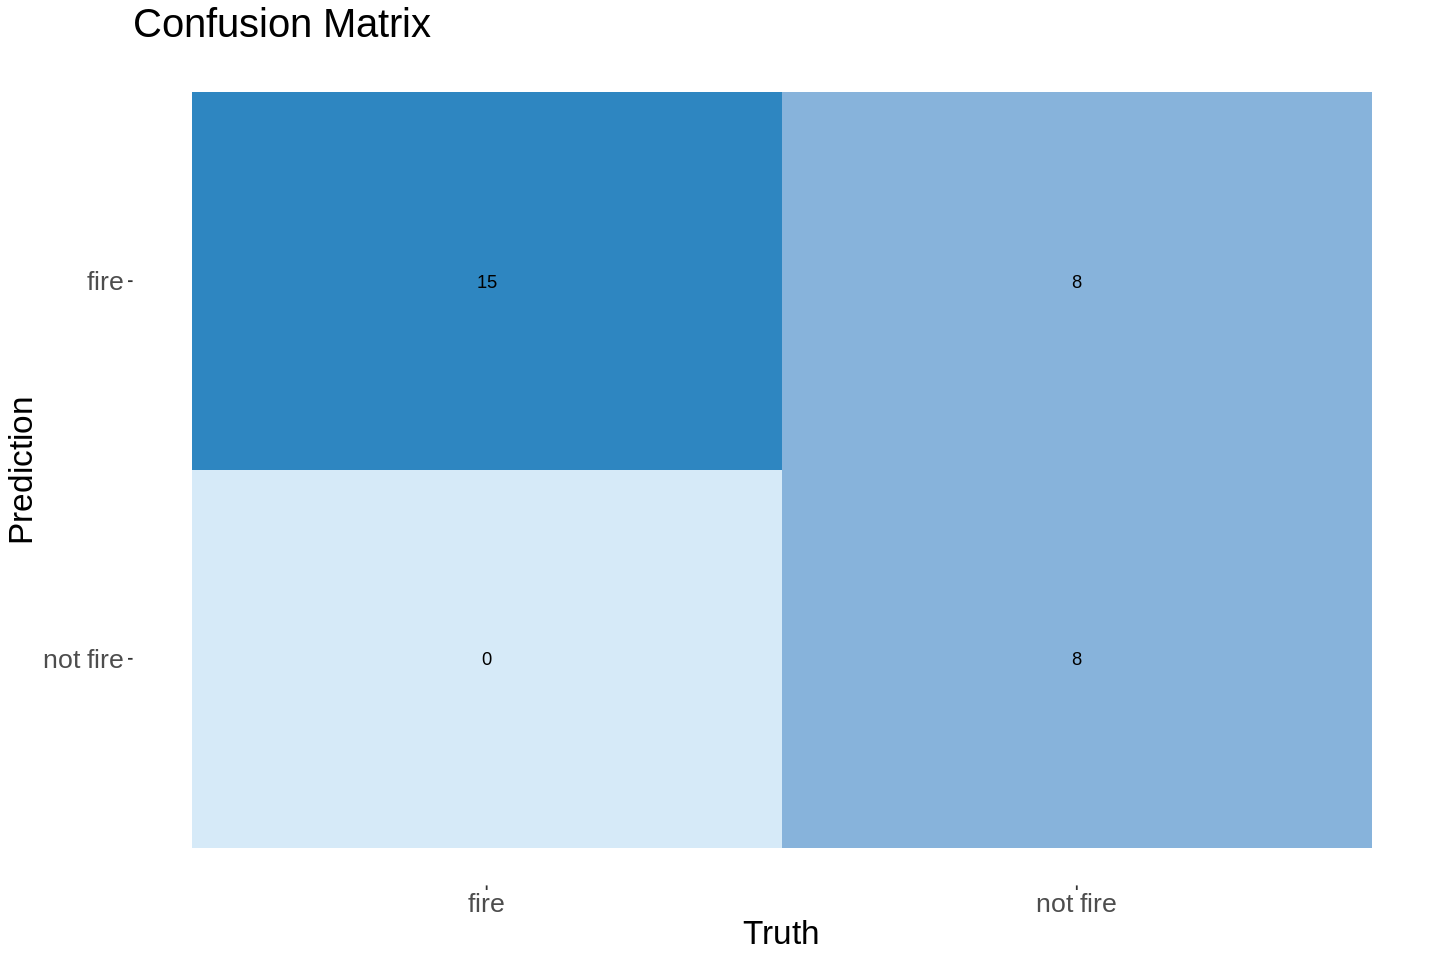

In [17]:
autoplot(fire_confmat, type = "heatmap") +
  scale_fill_gradient(low="#D6EAF8",high = "#2E86C1")+
    ggtitle("Confusion Matrix") +
    theme(text = element_text(size = 20))

Figure 6: Plot of confusion matrix results

The confusion matrix shows 15 observations are correctly predicted as fire, and 8 are correctly predicted as not fire. Therefore, the classifier labeled 15 + 8 = 23 observations correctly. However, there are also some mistakes; in particular, it classifies 8 observations as fire when they are truly not fire. In other words, $\frac {8}{8+8}$ * 100% = 50% of not fires are wrongly predicted. 

**Discussion**

- Summary

Overall, the classifier was approximately 74.2% accurate on the test data set with K = 22. To be more exact, there was a total of 31 observations in the testing set. Our model was able to predict 23 observations with the correct class labels and 8 observations was wrongly predicted. Based on our confusion matrix (Figure 6), we could also see that there were a total of 16 observations with a class label “not fire”; however, there only 8 predictions matched the truth, and the other 8 ($\frac {8}{8+8}$ * 100% = 50%) were not. Therefore, our model is more likely to predict fires where there are none (8 results) than predicting safe conditions where there is a fire (0 results). If these results are generally applicable in all cases, we can say that this classifier is better than a classifier of the same accuracy that occasionally predicts no fires when there are fires, because it is ultimately more dangerous to not be able to detect a fire than to give out a false alarm.

However, we are unsure of whether our accuracy of 74% is a conclusive result, as we only had around 15-16 data points from each class in our testing set. We believe that, if we had a wider range of data to test with, our accuracy and metrics may change, as 31 points in the testing set is not enough to definitively evaluate the accuracy of our classifier.

- Was this expected?

Although the accuracy (74.2%) may seem low, this was an expected outcome with reference to Figure 3. According to our research, wind speed is an important factor that affects the spreading of fire, the faster the wind blows, the faster the fire will spread once it starts. However, once we made the plot, we could see that the wind speed predictor is insignificant for predicting the Classes column since the points on each boxplot are so alike. Compared to surrounding boxplots, the standard deviations and points are significantly more distinguishable, suggesting that they provide crucial information regarding the likelihood of a fire. Therefore, in this case, wind speed is not the most significant factor when it comes to predicting forest fires.

- Impact

Modeling is one of the well-used methodologies to monitor forest fires. For example, our classification model can help give an indication of a forest fire by taking multiple predictors into account. Governments can integrate temperature, relative humidity, wind speed, and daily rainfall to predict the forest fires at regional levels. As a result, warnings and recommendations for actions including fire bans and emergency evacuation can be provided to communities. With the proper research, there may also be tremendous environmental and economic benefits and the prevention of losing human lives. 

For our current classifier with wind speed as a predictor, the confusion matrix indicates that our classifier labeled "not fire" is correct 8 times and incorrectly 8 times, but "fire" all correct. Thus, even if our accuracy is 74 %, we should still say the classification has above average appropriate performance for the application as it did not predict no fires when there are fires. Implementing our project cannot afford wrongly predicted "fire" because when fires occur, people and the environment are at risk. For example, cities might be evacuated, or resources may be allocated to prevention if the conditions favored a fire within our classifier.

Although our model is better than the other models with the same accuracy, it does not imply that our classifier is "flawless." We still need to improve the accuracy of predicting "not fire". Even though there is no catastrophic damage/result if we do not make improvements, it might cause panic in local communities.


- Future Questions

This model can be enhanced in the future by making it more flexible to show which specific predictors have a greater impact on the classifier. We can also gather more data to test if wind speed really has barely any influence on predicting forest fires in regions. Not only the environmental factors can be predictors, but human activities should also take into account in future exploration. Future inquiries should additionally consider how humans impact the environment, whether it be the distribution of vegetation or accidentally starting fires (Fekir et al., 2022).


**References**

Abid, F., & Izeboudjen, N. (2020). Predicting forest fire in Algeria using data mining techniques: Case study of the decision tree algorithm. Advances in Intelligent Systems and Computing, 363–370. https://doi.org/10.1007/978-3-030-36674-2_37

Ayache, F., Santana, V. M., & Baeza, M. J. (2020). Environmental and anthropogenic drivers of coniferous species distribution in Mediterranean drylands from North West Algeria. Folia Geobotanica, 55(1), 15–27.
https://doi.org/10.1007/s12224-020-09362-8

Belgherbi, B., Benabdeli, K., & Mostefai, K. (2018). Mapping the risk forest fires in Algeria: Application of the forest of guetarnia in western Algeria. Ekológia (Bratislava), 37(3), 289–300. https://doi.org/10.2478/eko-2018-0022

FEKIR, Y., HAMADOUCHE, M. A., & ANTEUR, D. (2022). Integrated Approach Using Geographic Information System and multi criteria decision analysis method for forest fire risk mapping in northwestern Algeria. PLANT ARCHIVES, 351–359. https://doi.org/10.51470/plantarchives.2022.v22.no1.055